# ECRQ Tables and Graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col

In [2]:
# Load the data
dtype_dict = {
    'white_supply_any_avg_tract': np.float32,
    'black_supply_any_avg_tract': np.float32,
    'am_indian_alaska_native_supply_any_avg_tract': np.float32,
    'asian_supply_any_avg_tract': np.float32,
    'native_hawaiian_pacific_islander_supply_any_avg_tract': np.float32,
    'other_race_supply_any_avg_tract': np.float32,
    'two_or_more_races_supply_any_avg_tract': np.float32,
    'hispanic_latino_supply_any_avg_tract': np.float32,
    'state': np.int32,
    'county': np.int32,
    'tract': np.int32,
    'median_household_income': np.float32,
    'gini_index': np.float32,
    'educational_attainment': np.float32,
    'employment_status': np.float32,
    'housing_tenure': np.float32,
    'poverty_status': np.float32,
    'commute_time': np.float32,
    'without_health_insurance': np.float32,
    'labor_force_status': np.float32,
    'total_population_25_years_and_over': np.float32,
    'white': np.float32,
    'black': np.float32,
    'am_indian_alaska_native': np.float32,
    'asian': np.float32,
    'native_hawaiian_pacific_islander': np.float32,
    'other_race': np.float32,
    'two_or_more_races': np.float32,
    'hispanic_latino': np.float32,
    'total_tract_population': np.int32
}


data = pd.read_csv('../data/acs_data.csv', dtype=dtype_dict)  # Replace with the path to your data file

# Rename the variables
data.rename(columns={
    'white_supply_any_avg_tract': 'White',
    'black_supply_any_avg_tract': 'Black',
    'am_indian_alaska_native_supply_any_avg_tract': 'American Indian Alaska Native',
    'asian_supply_any_avg_tract': 'Asian',
    'native_hawaiian_pacific_islander_supply_any_avg_tract': 'Native Hawaiian Pacific Islander',
    'other_race_supply_any_avg_tract': 'Other Race',
    'two_or_more_races_supply_any_avg_tract': 'Two or More Races',
    'hispanic_latino_supply_any_avg_tract': 'Hispanic Latino',
    'median_household_income': 'Median Household Income',
    'gini_index': 'Gini Index',
    'educational_attainment': 'Educational Attainment',
    'employment_status': 'Employment Status',
    'housing_tenure': 'Housing Tenure',
    'poverty_status': 'Poverty Status',
    'commute_time': 'Commute Time',
    'without_health_insurance': 'Without Health Insurance',
    'labor_force_status': 'Labor Force Status',
    'total_population_25_years_and_over': 'Total Population 25 Years and Over'
}, inplace=True)

# calculate state population
state_population = data.groupby('state')['total_tract_population'].transform('sum')

# create tract_weight
data['tract_weight'] = data['total_tract_population'] / state_population

In [3]:
data.head()

,White,Black,American Indian Alaska Native,Asian,Native Hawaiian Pacific Islander,Other Race,Two or More Races,Hispanic Latino,state,county,...,white,black,am_indian_alaska_native,asian,native_hawaiian_pacific_islander,other_race,two_or_more_races,hispanic_latino,total_tract_population,tract_weight
0,0.027303,0.040353,0.000002,6.304092e-07,0.000000e+00,0.081921,7.468044e-07,0.062561,27,27001,...,0.000458,0.000042,0.000741,0.000063,0.000000,0.000308,0.000133,0.000150,2240,0.000404
1,0.229566,0.668083,0.097253,6.680830e-01,3.401247e-08,0.047095,5.170830e-01,0.473471,27,27001,...,0.000446,0.000020,0.001586,0.000004,0.001367,0.000048,0.000732,0.000067,2284,0.000411
2,0.463983,0.341689,0.301611,4.202191e-01,0.000000e+00,0.420219,4.140471e-01,0.580718,27,27001,...,0.000719,0.000079,0.000672,0.000048,0.000000,0.000019,0.000514,0.000240,3483,0.000627
3,0.413980,0.568615,0.921216,0.000000e+00,0.000000e+00,0.141978,7.928232e-01,0.728222,27,27001,...,0.000593,0.000070,0.002534,0.000000,0.000000,0.000019,0.000375,0.000134,2970,0.000535
4,0.012008,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.008861,27,27001,...,0.000406,0.000011,0.000000,0.000052,0.000000,0.000000,0.000085,0.000033,1905,0.000343


## Summary Statistics

In [4]:
variables = {
    'White': 'white',
    'Black': 'black',
    'American Indian Alaska Native': 'am_indian_alaska_native',
    'Asian': 'asian',
    'Native Hawaiian Pacific Islander': 'native_hawaiian_pacific_islander',
    'Other Race': 'other_race',
    'Two or More Races': 'two_or_more_races',
    'Hispanic Latino': 'hispanic_latino',
    'Median Household Income': 'median_household_income',
    'Gini Index': 'gini_index',
    'Educational Attainment': 'educational_attainment',
    'Employment Status': 'employment_status',
    'Housing Tenure': 'housing_tenure',
    'Poverty Status': 'poverty_status',
    'Commute Time': 'commute_time',
    'Without Health Insurance': 'without_health_insurance',
    'Labor Force Status': 'labor_force_status',
    'Total Population 25 Years and Over': 'total_population_25_years_and_over'
}

racial_groups = list(variables.keys())[:8]
racial_weights = list(variables.values())[:8]
other_covariates = list(variables.keys())[8:]

summary_statistics = {}

# Calculate weighted averages and standard deviations for racial groups
for group, weight in zip(racial_groups, racial_weights):
    weighted_mean = (data[group] * data[weight]).sum()
    weighted_std = np.sqrt((data[weight] * (data[group] - weighted_mean)**2).sum())
    summary_statistics[group] = {'mean': weighted_mean, 'std': weighted_std}

# Calculate weighted averages and standard deviations for other covariates using 'tract_weight' as weight
for covariate in other_covariates:
    weighted_mean = (data[covariate] * data['tract_weight']).sum() / data['tract_weight'].sum()
    weighted_std = np.sqrt((data['tract_weight'] * (data[covariate] - weighted_mean)**2).sum() / data['tract_weight'].sum())
    summary_statistics[covariate] = {'mean': weighted_mean, 'std': weighted_std}

# Convert the dictionary to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics).T

# Format the summary statistics table
summary_statistics_df = summary_statistics_df.applymap('{:.2f}'.format)
summary_statistics_df['std'] = '(' + summary_statistics_df['std'] + ')'
summary_statistics_df.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'}, inplace=True)

print(summary_statistics_df)


                                        Mean Std Deviation
White                                   0.57        (0.28)
Black                                   0.59        (0.24)
American Indian Alaska Native           0.59        (0.37)
Asian                                   0.54        (0.24)
Native Hawaiian Pacific Islander        0.55        (0.34)
Other Race                              0.59        (0.27)
Two or More Races                       0.59        (0.28)
Hispanic Latino                         0.59        (0.27)
Median Household Income             76723.79    (28606.62)
Gini Index                              0.41        (0.06)
Educational Attainment                  0.24        (0.10)
Employment Status                       0.67        (0.08)
Housing Tenure                          0.73        (0.20)
Poverty Status                          0.10        (0.09)
Commute Time                            0.92        (0.04)
Without Health Insurance                0.01        (0.0

## CDF Plots

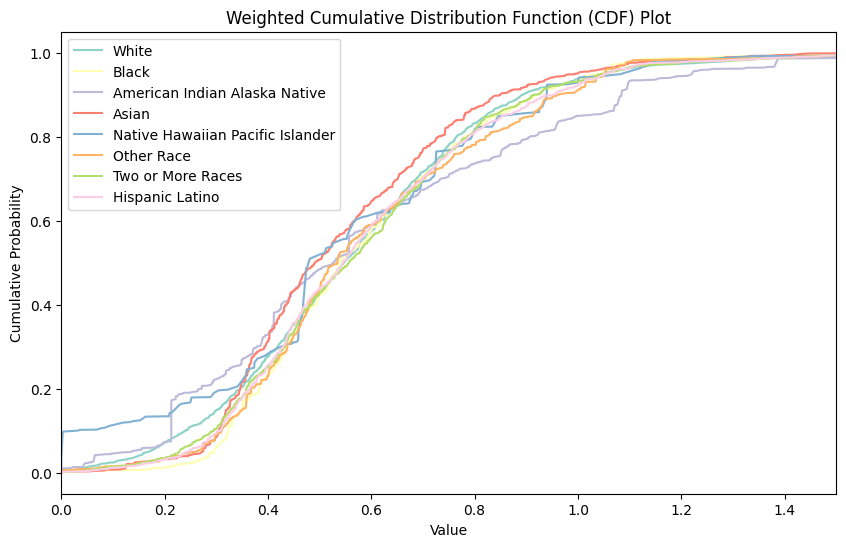

In [5]:
# CDF plot
race_variables = [
    'White', 
    'Black', 
    'American Indian Alaska Native', 
    'Asian', 
    'Native Hawaiian Pacific Islander',
    'Other Race', 
    'Two or More Races', 
    'Hispanic Latino',
]

colors = [
    '#8dd3c7', 
    '#ffffb3', 
    '#bebada', 
    '#fb8072', 
    '#80b1d3', 
    '#fdb462', 
    '#b3de69', 
    '#fccde5']

weight_map = {
    'White': 'white',
    'Black': 'black',
    'American Indian Alaska Native': 'am_indian_alaska_native',
    'Asian': 'asian',
    'Native Hawaiian Pacific Islander': 'native_hawaiian_pacific_islander',
    'Other Race': 'other_race',
    'Two or More Races': 'two_or_more_races',
    'Hispanic Latino': 'hispanic_latino',
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables, colors):
    # Get the weights for this variable
    weights = data[weight_map[var]]
    
    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))
    
    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)
    
    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]
    
    ax.plot(values, cumulative, label=var, color=color)

ax.set_title('Weighted Cumulative Distribution Function (CDF) Plot')
ax.set_xlabel('Value')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='upper left')

# Set x-axis limit
ax.set_xlim(0, 1.5)

plt.show()

## Matrix of Differences

In [6]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix = pd.DataFrame(index=race_variables, columns=race_variables)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables:
    for col_var in race_variables:
        if row_var != col_var:
            row_weighted_mean = (data[row_var] * data[weight_map[row_var]]).sum() / data[weight_map[row_var]].sum()
            col_weighted_mean = (data[col_var] * data[weight_map[col_var]]).sum() / data[weight_map[col_var]].sum()
            matrix.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean


In [7]:
matrix

,White,Black,American Indian Alaska Native,Asian,Native Hawaiian Pacific Islander,Other Race,Two or More Races,Hispanic Latino
White,NaN,-0.018817,-0.021563,0.026921,0.020044,-0.022033,-0.016453,-0.015735
Black,0.018817,NaN,-0.002746,0.045738,0.038861,-0.003216,0.002364,0.003082
American Indian Alaska Native,0.021563,0.002746,NaN,0.048484,0.041607,-0.00047,0.00511,0.005828
Asian,-0.026921,-0.045738,-0.048484,NaN,-0.006877,-0.048954,-0.043374,-0.042656
Native Hawaiian Pacific Islander,-0.020044,-0.038861,-0.041607,0.006877,NaN,-0.042077,-0.036497,-0.035779
Other Race,0.022033,0.003216,0.00047,0.048954,0.042077,NaN,0.00558,0.006298
Two or More Races,0.016453,-0.002364,-0.00511,0.043374,0.036497,-0.00558,NaN,0.000718
Hispanic Latino,0.015735,-0.003082,-0.005828,0.042656,0.035779,-0.006298,-0.000718,NaN


## Matrix of Differences with color

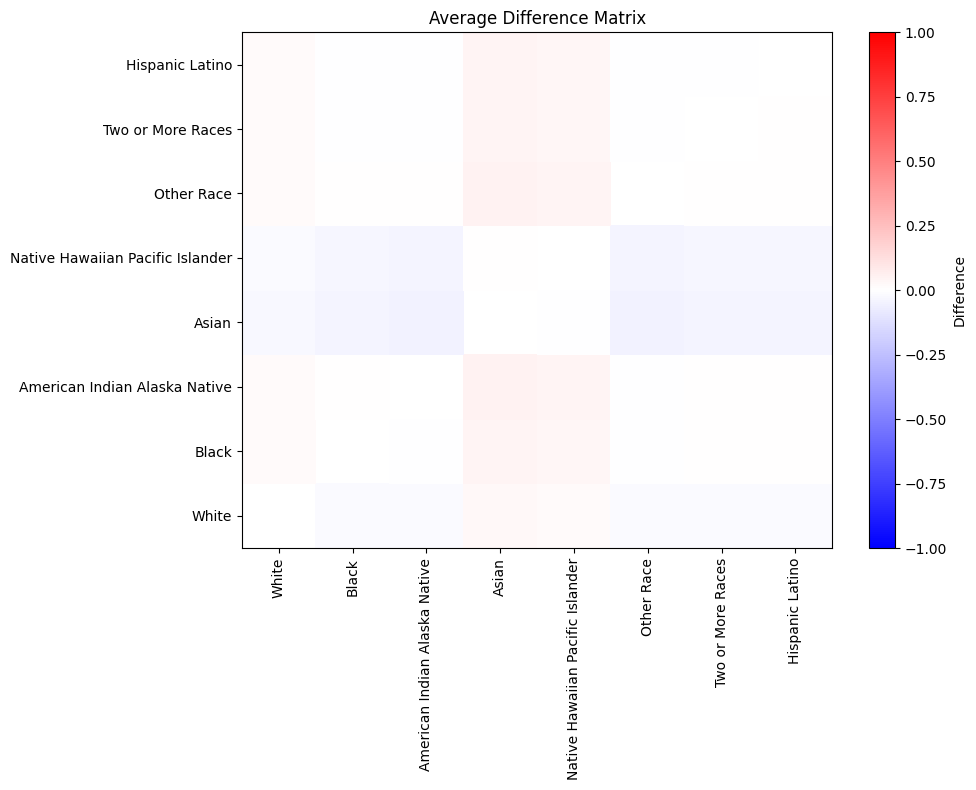

In [8]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix = matrix.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap('bwr')

plt.figure(figsize=(10, 8))
plt.pcolor(matrix, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label='Difference')
plt.xticks(np.arange(0.5, len(matrix.columns), 1), matrix.columns, rotation='vertical', fontsize=10)
plt.yticks(np.arange(0.5, len(matrix.index), 1), matrix.index, fontsize=10)
plt.title('Average Difference Matrix')
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

## Regression Tables

In [9]:
def run_regression_analysis(covariates, outcome_variables, data, scalar=1):
    regression_results = {}
    rmse_results = {}

    for outcome in outcome_variables:
        X = sm.add_constant(data[covariates])
        y = data[outcome] * scalar

        model = sm.OLS(y, X)
        result = model.fit()

        rmse = np.sqrt(mean_squared_error(y, result.predict()))

        regression_results[outcome] = result
        rmse_results[outcome] = rmse

    return regression_results, rmse_results

### Asian

In [10]:
# Define the covariates
covariates = other_covariates # This is a list of covariates

# Define the outcome variables
outcome_variables = racial_groups  # This is a list of outcome variables

# Define the scalar
scalar = 100  # Replace with your desired scalar

# Call the function to run the regression analysis
regression_results, rmse_results = run_regression_analysis(covariates, outcome_variables, data, scalar)

# Generate the summary table
summary_table = summary_col(
    list(regression_results.values()),
    stars=True,
    float_format='%.3f',
    model_names=outcome_variables,
    info_dict={'N': lambda x: f"{x.nobs:.0f}",
               'R2': lambda x: f"{x.rsquared_adj:.3f}"}
)

# Convert RMSE results to a DataFrame and concatenate with summary table
rmse_df = pd.DataFrame(rmse_results, index=['RMSE'])
summary_df = pd.concat([summary_table.tables[0], rmse_df])


In [11]:
summary_table

,White,Black,American Indian Alaska Native,Asian,Native Hawaiian Pacific Islander,Other Race,Two or More Races,Hispanic Latino
const,51.592*,105.334***,59.124,66.137**,45.120**,67.709*,62.147*,55.472*
,(26.581),(31.435),(36.932),(31.599),(21.509),(36.441),(31.775),(29.400)
Median Household Income,-0.000***,-0.000***,-0.000**,-0.000,-0.000,-0.000***,-0.000***,-0.000**
,(0.000),(0.000),(0.000),(0.000),(0.000),(0.000),(0.000),(0.000)
Gini Index,33.251*,-10.603,19.487,5.487,18.162,24.557,27.246,23.249
,(18.334),(21.682),(25.473),(21.795),(14.836),(25.135),(21.916),(20.278)
Educational Attainment,47.802***,69.150***,5.973,71.476***,-10.575,30.224,44.758***,40.671**
,(14.413),(17.045),(20.026),(17.134),(11.663),(19.760),(17.229),(15.942)
Employment Status,178.940***,141.807**,148.377*,137.384**,-2.193,53.492,191.458***,186.496***
,(55.862),(66.064),(77.617),(66.408),(45.204),(76.585),(66.777),(61.788)
